## Assess the impact of atmosphere on offset time-seris

Run the following to prepare the datasets in HDF5/MintPy format for this notebook:

```bash
prep_gim_tec.ipynb                                        # calc SUB/JPH TEC
iono_tec.py timeseriesRg.h5 -g inputs/geometryRadar.h5    # calc JPL/COD TEC
offset_timeseries.py -t ChileSenAT149.txt --plot          # calc SAR, SET and ERA5
```

Run the following notebook to add the location of the study area:

+ [Fig_AOI](./Fig_AOI.ipynb)

In [20]:
%matplotlib inline
import os
import datetime as dt
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt, ticker, gridspec
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy import tsview
from ipynb.fs.full import utils
figsize_ts  = [9, 2.5]
figsize_dot = [2.5, 2.5]

# config
n = 3                                 # number of med abs dev
dt_s1ab = dt.datetime(2016, 10, 7)    # dateime separating S1A and S1B
dt2 = dt.datetime(2017, 9, 1)
save = True

# location of interest
lalo = [-21.29, -69.58]; box_suffix = 'boxCL'   # box in the center left with low  altitude; box = (10,  55,  20, 70) for SenAT149
lalo = [-21.30, -67.39]; box_suffix = 'boxLR'   # box in the lower right with high altitude; box = (200, 15, 215, 30) for SenAT149

# dir
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenDT156')
#proj_dir = os.path.expanduser('~/data/geolocation/KyushuAlos2DT23');  lalo = None; box_suffix = None

proj_name = os.path.basename(proj_dir)
work_dir = os.path.join(proj_dir, 'offset_comp')
if box_suffix is not None:
    work_dir = os.path.join(work_dir, box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

# matplotlib setup
plt.rcParams.update({'font.size': 12})
if proj_name == 'ChileSenDT156':
    plt.rcParams.update({'lines.linewidth': 1.5})
else:
    plt.rcParams.update({'lines.linewidth': 3.0})

Go to directory /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR


### 0. Read all time-series

In [23]:
# data files
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
mask_file = os.path.join(proj_dir, 'mintpy_offset/maskResInv.h5')
sar_file  = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg.h5')
era_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/ERA5.h5')
set_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/SET.h5')
tec_files = [
    # opt 1 - used TEC [choose ONE ONLY]
    os.path.join(proj_dir, 'mintpy_offset/inputs/TECjhr.h5'),
    #os.path.join(proj_dir, 'mintpy_offset/inputs/TECsub.h5'),
    # opt 2 - as background comparison
    os.path.join(proj_dir, 'mintpy_offset/inputs/TECjlr.h5'),
    os.path.join(proj_dir, 'mintpy_offset/inputs/TECclr.h5'),
]

fnames = [sar_file] + tec_files + [set_file, era_file]
dnames = ['SAR'] + [os.path.splitext(os.path.basename(i))[0] for i in fnames[1:]]

# date info
date_list = timeseries(sar_file).get_date_list()
num_date = len(date_list)

# local solar time
atr = readfile.read_attribute(sar_file)
utc_time = dt.datetime.fromisoformat(atr['startUTC'])
longitude = (float(atr['LON_REF1']) + float(atr['LON_REF2'])) / 2
solar_time = ptime.utc2solar_time(utc_time, longitude)
print('local solar time: {}'.format(solar_time))

# lalo --> box
if lalo is None:
    box = None
else:
    coord = ut.coordinate(atr, lookup_file=geom_file)
    y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
    win = 10
    box = (x-win, y-win, x+win+1, y+win+1)

# read data files into iDict
iDict = {}
for fname, dname in zip(fnames, dnames):
    if not os.path.isfile(fname):
        next
    else:
        print('read data from file: {}'.format(fname))
        ts_data = readfile.read(fname, box=box)[0].reshape(num_date, -1)
        # mask
        if dname == 'SAR':
            ## reference in time
            #ts_data -= np.tile(ts_data[ref_ind, :].reshape(1, -1), (ts_data.shape[0], 1))
            # mask out unreliable SAR offset, including 
            # 1. pixels not inverted, thus with default zero value
            # 2. pixels inverted, but unreliable due to large inversion residual
            mask = readfile.read(mask_file, box=box)[0].flatten()
            ts_data[:, mask==0] = np.nan
        else:
            # mask out invalid pixels
            ts_data[ts_data == 0] = np.nan
        iDict[dname] = {}
        iDict[dname]['data'] = ts_data
        iDict[dname]['med'] = np.nanmedian(ts_data, axis=-1)
        iDict[dname]['mad'] = ut.median_abs_deviation(ts_data)

# maskout anomaly date of 2015-04-02 for Sentinel-1 desc track 156
mask_anomaly = True
if mask_anomaly and proj_name == 'ChileSenDT156':
    ex_dates = ['20150402']
    print('Ignore anomaly dates: {}'.format(ex_dates))
    flag = [i in ex_dates for i in date_list]
    for dname in iDict.keys():
        iDict[dname]['med'][flag] = np.nan

local solar time: 2014-10-16 05:43:18.918381
read data from file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/timeseriesRg.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/TECjhr.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/TECjlr.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/TECclr.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/SET.h5
read data from file: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset/inputs/ERA5.h5
Ignore anomaly dates: ['20150402']


### 1. SAR vs. TEC

Min/max:
  SAR   : nan / nan cm
  TECclr: nan / nan cm
  TECjlr: nan / nan cm
  TECjhr: nan / nan cm
RMSE:
  SAR         : 8.7 cm
  SAR - TECclr: 8.0 cm
  SAR - TECjlr: 7.8 cm
  SAR - TECjhr: 8.8 cm
save figure to file /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR/TS_SAR_vs_TECjhr.pdf
$R^2$ = 0.22
$RMSE$ = 8.8 cm

save figure to file /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR/DOT_SAR_vs_TECjhr.pdf


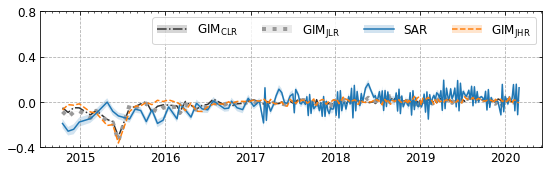

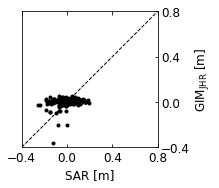

In [24]:
### Read Data
x1 = ptime.date_list2vector(date_list)[0]
# dset 1: SAR
y1  = np.array(iDict[dnames[0]]['med'])
y1e = np.array(iDict[dnames[0]]['mad']) * n
# dset 2: JHR/SUB TEC
y2  = np.array(iDict[dnames[1]]['med']) * -1
y2e = np.array(iDict[dnames[1]]['mad']) * n
# dset 3: JLR TEC
y3  = np.array(iDict[dnames[2]]['med']) * -1
y3e = np.array(iDict[dnames[2]]['mad']) * n
# dset 4: CLR TEC
y4  = np.array(iDict[dnames[3]]['med']) * -1
y4e = np.array(iDict[dnames[3]]['mad']) * n
# align other data to SAR with a constant
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)
y3 -= np.nanmedian(y3 - y1)
y4 -= np.nanmedian(y4 - y1)
print('Min/max:')
print(f'  {dnames[0]:<6}: {np.min(y1*100):.1f} / {np.max(y1*100):.1f} cm')
print(f'  {dnames[3]:<6}: {np.min(y4*100):.1f} / {np.max(y4*100):.1f} cm')
print(f'  {dnames[2]:<6}: {np.min(y3*100):.1f} / {np.max(y3*100):.1f} cm')
print(f'  {dnames[1]:<6}: {np.min(y2*100):.1f} / {np.max(y2*100):.1f} cm')

# RMSE
print('RMSE:')
rmse = ut.root_mean_sq_error(y1);     print('  SAR         : {:.1f} cm'.format(rmse*100))
rmse = ut.root_mean_sq_error(y1, y4); print('  SAR - {}: {:.1f} cm'.format(dnames[3], rmse*100))
rmse = ut.root_mean_sq_error(y1, y3); print('  SAR - {}: {:.1f} cm'.format(dnames[2], rmse*100))
rmse = ut.root_mean_sq_error(y1, y2); print('  SAR - {}: {:.1f} cm'.format(dnames[1], rmse*100))

### Figure 1 - TS
if proj_name == 'ChileSenAT149':
    vstep = 0.4; ylim = [-0.8, 0.4]; loc = 'lower right'; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.4; ylim = [-0.4, 0.8]; loc = 'best';        xlim = None
elif proj_name == 'KyushuAlos2DT23':
    vstep = 5;   ylim = [-15, 5];    loc = 'best';        xlim = None
mks = ['-.',':', '-', '--']
cs = ['0.2', '0.6', 'C0', 'C1']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize_ts)
ps = []
for i, (y, ye, c, m) in enumerate(zip([y4, y3, y1, y2], [y4e, y3e, y1e, y2e], cs, mks)):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    ye = np.array(ye)[flag]
    x  = np.array(x1)[flag]
    p0  = ax.fill_between(x, y-ye, y+ye, fc=c, ec='none', alpha=0.2)
    kwargs = dict(linewidth=1.5) if i == 0 else dict(linewidth=4.0) if i == 1 else dict()
    p1, = ax.plot(x, y, m, color=c, ms=4, **kwargs)
    ps.append((p0, p1))
# axis format
utils.adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim, ylabel=None)
labels = ['GIM$_\mathrm{{{}}}$'.format(dnames[3].replace('TEC','').upper()),
          'GIM$_\mathrm{{{}}}$'.format(dnames[2].replace('TEC','').upper()),
          'GIM$_\mathrm{{{}}}$'.format(dnames[1].replace('TEC','').upper())]
xname = labels[-1]
ax.legend(handles=ps, labels=[labels[-3], labels[-2], 'SAR', labels[-1]], loc=loc, ncol=len(ps), handlelength=2.5)
#ax.annotate('RMSE: {:.1f} cm'.format(ut.root_mean_sq_error(y1, y3)*100.), xy=(dt.datetime(2016,1,1), 0.3))
#ax.annotate('RMSE: {:.1f} cm'.format(ut.root_mean_sq_error(y1, y3)*100.), xy=(dt.datetime(2016,5,1), -0.6))
# output
out_fig = os.path.join(work_dir, 'TS_SAR_vs_{}.pdf'.format(dnames[1]))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

### Figure 2 - DOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize_dot)
utils.plot_dot_figure(ax, x=y1, y=y2, vlim=ylim, vstep=vstep)
#fig.tight_layout()
ax.set_xlabel('{} [m]'.format('SAR'), color='k')
ax.set_ylabel('{} [m]'.format(xname), color='k', labelpad=None)
# output
out_fig = os.path.join(work_dir, 'DOT_SAR_vs_{}.pdf'.format(dnames[1]))
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

plt.show()

### 2. SAR - TEC vs. SET

save figure to file /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR/TS_SAR_TECjhr_vs_SET.pdf
$R^2$ = 0.42
$RMSE$ = 10.7 cm

save figure to file /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR/DOT_SAR_TECjhr_vs_SET.pdf


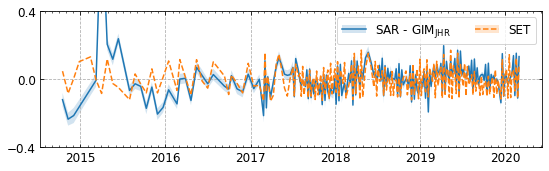

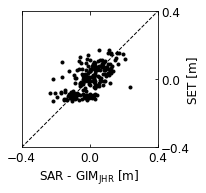

In [23]:
### Read Data
x1 = ptime.date_list2vector(date_list)[0]
# dset 1: SAR - TEC
y1  = np.array(iDict['SAR']['med'])
y1 -= np.array(iDict[dnames[1]]['med']) * -1
y1e = (iDict['SAR']['mad']**2 + iDict[dnames[1]]['mad']**2) ** 0.5 * n
# dset 2: SET
y2  = np.array(iDict['SET']['med'])
y2e = np.array(iDict['SET']['mad']) * n
# align all data with a constant
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)

### Figure 1 - TS
if proj_name == 'ChileSenAT149':
    vstep = 0.3; ylim = [-0.3, 0.3]; loc = 'lower right'; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.4; ylim = [-0.4, 0.4]; loc = 'best';        xlim = None
elif proj_name == 'KyushuAlos2DT23':
    vstep = 3;   ylim = [-3, 3];     loc = 'best';        xlim = None

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize_ts)
ps = []
for i, (y, ye, c, m) in enumerate(zip([y1, y2], [y1e, y2e], ['C0', 'C1'], ['-', '--'])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    ye = np.array(ye)[flag]
    x  = np.array(x1)[flag]
    p0  = ax.fill_between(x, y-ye, y+ye, fc=c, ec='none', alpha=0.2)
    p1, = ax.plot(x, y, m, color=c, ms=4)
    ps.append((p0, p1))
# axis format
utils.adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim, ylabel=None)
xname = 'SAR - GIM$_\mathrm{{{}}}$'.format(dnames[1][-3:].upper())
ax.legend(labels=[xname, 'SET'], handles=ps, loc=loc, ncol=len(ps))
#fig.tight_layout()
# output
out_fig = os.path.join(work_dir, 'TS_SAR_{}_vs_SET.pdf'.format(dnames[1]))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

### Figure 2 - DOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize_dot)
utils.plot_dot_figure(ax, x=y1, y=y2, vlim=ylim, vstep=vstep)
#fig.tight_layout()
ax.set_xlabel('{} [m]'.format(xname), color='k')
ax.set_ylabel('{} [m]'.format('SET'), color='k', labelpad=-4)
# output
out_fig = os.path.join(work_dir, 'DOT_SAR_{}_vs_SET.pdf'.format(dnames[1]))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

plt.show()

### 3. SAR - TEC - SET vs. ERA5

save figure to file /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR/TS_SAR_TECjhr_SET_vs_ERA5.pdf
$R^2$ = 0.18
$RMSE$ = 10.6 cm

save figure to file /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR/DOT_SAR_TECjhr_SET_vs_ERA5.pdf


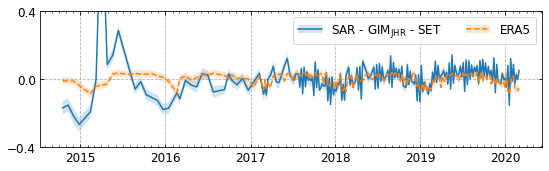

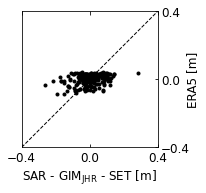

In [24]:
### Read Data
# dset 1: SAR - TEC
x1 = ptime.date_list2vector(date_list)[0]
y1  = np.array(iDict['SAR']['med'])
y1 -= np.array(iDict[dnames[1]]['med']) * -1
y1 -= np.array(iDict['SET']['med'])
y1e = (iDict['SAR']['mad']**2 + iDict[dnames[1]]['mad']**2 + iDict['SET']['mad']**2) ** 0.5 * n
# dset 2: ERA5
y2  = np.array(iDict['ERA5']['med'])
y2e = np.array(iDict['ERA5']['mad']) * n
# align all data with a constant
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)

### Figure 1 - TS
if proj_name == 'ChileSenAT149':
    vstep = 0.3; ylim = [-0.3, 0.3]; loc = 'best'; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.4; ylim = [-0.4, 0.4]; loc = 'best'; xlim = None
elif proj_name == 'KyushuAlos2DT23':
    vstep = 3;   ylim = [-3, 3];     loc = 'best'; xlim = None

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize_ts)
ps = []
for i, (y, ye, c, m) in enumerate(zip([y1, y2], [y1e, y2e], ['C0', 'C1'], ['-', '--'])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    ye = np.array(ye)[flag]
    x  = np.array(x1)[flag]
    p0  = ax.fill_between(x, y-ye, y+ye, fc=c, ec='none', alpha=0.2)
    p1, = ax.plot(x, y, m, color=c, ms=4)
    ps.append((p0, p1))
# axis format
utils.adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim, ylabel=None)
xname = 'SAR - GIM$_\mathrm{{{}}}$ - SET'.format(dnames[1][-3:].upper())
ax.legend(labels=[xname, 'ERA5'], handles=ps, loc=loc, ncol=len(ps))
#fig.tight_layout()
# output
out_fig = os.path.join(work_dir, 'TS_SAR_{}_SET_vs_ERA5.pdf'.format(dnames[1]))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

### Figure 2 - DOT
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize_dot)
utils.plot_dot_figure(ax, x=y1, y=y2, vlim=ylim, vstep=vstep)
#fig.tight_layout()
ax.set_xlabel('{} [m]'.format(xname),  color='k')
ax.set_ylabel('{} [m]'.format('ERA5'), color='k', labelpad=-4)
# output
out_fig = os.path.join(work_dir, 'DOT_SAR_{}_SET_vs_ERA5.pdf'.format(dnames[1]))
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

plt.show()

## RMSE after anomaly

In [19]:
## RMSE after anomaly
flag = x > dt2
rmse = np.sqrt(np.nansum((y2[flag] - y1[flag])**2) / (np.nansum(flag) - 1))
print('RMSE after {}: {:.2f} cm'.format(dt2.date(), rmse*100))

RMSE after 2017-09-01: 6.23 cm


## Apply noise reductions: TEC, SET and ERA5

By run `offset_timeseries.py -t template_file` for each of the dataset.

## Plot residual time-series for POI

Go to directory: /Users/yunjunz/data/geolocation/ChileSenDT156/mintpy_offset
tsview.py timeseriesRg_gimTEC_SET_ERA5.h5 --save --figsize 8 3 --lalo -21.3 -67.39 --ylim -40 120
open timeseries file: timeseriesRg_gimTEC_SET_ERA5.h5
exclude date:['20150402']
data   coverage in y/x: (0, 0, 232, 157)
subset coverage in y/x: (0, 0, 232, 157)
data   coverage in lat/lon: None
subset coverage in lat/lon: None
------------------------------------------------------------------------
DESCENDING orbit -> flip left-right
reading timeseries from file timeseriesRg_gimTEC_SET_ERA5.h5 ...
reference to date: 20191014
read mask from file: maskResInv.h5
data    range: [-165.21875, 180.14827] cm
display range: [-37.830654, 124.26989] cm
figure size : [8.53, 6.00]
display data in transparency: 1.0
plotting in Y/X coordinate ...
plotting Data ...
plot points of interest
flip figure left and right

---------------------------------------
Y/X = 76, 47, lat/lon = -21.2950, -67.3860
[-21.05, -19.98, -26.05, -27.48

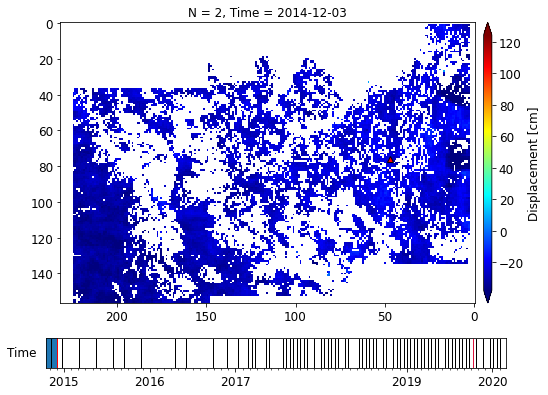

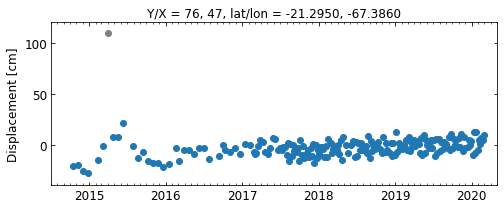

Go to directory: /Users/yunjunz/data/geolocation/ChileSenDT156/offset_comp/boxLR


In [47]:
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149'); ylim = ['-120', '40']
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenDT156'); ylim = ['-40', '120']
proj_name = os.path.basename(proj_dir)
os.chdir(os.path.join(proj_dir, 'mintpy_offset'));  print('Go to directory:', os.path.join(proj_dir, 'mintpy_offset'))

ts_file = 'timeseriesRg_subTEC_SET_ERA5.h5'
ts_file = 'timeseriesRg_gimTEC_SET_ERA5.h5'
iargs = [ts_file, '--save', '--figsize', '8', '3', '--lalo', str(lalo[0]), str(lalo[1])]
iargs += ['--ylim'] + ylim
#iargs += ['--ex', 'S1B_date.txt']
#iargs += ['--noverbose']
tsview.main(iargs)

os.chdir(work_dir);  print('Go to directory:', work_dir)

### RMSE of the pixel above for Sentinel-1 desc T156

In [34]:
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenDT156')
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
ts_file = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg_gimTEC_SET_ERA5.h5')
date_list = timeseries(ts_file).get_date_list()
dis_ts = ut.read_timeseries_lalo(lalo[0], lalo[1], ts_file, lookup_file=geom_file)[1]

# RMSE - original
print('RMSE (original): {:.1f} cm'.format(ut.root_mean_sq_error(dis_ts - np.nanmedian(dis_ts))*100.))

# RMSE - remove the two anomaly dates
ex_dates = ['20150402'] #, '20150613']
flag = [i not in ex_dates for i in date_list]
date_list = np.array(date_list)[flag].tolist()
dis_ts = dis_ts[flag]
print('RMSE (w/o 2015-04-02): {:.1f} cm'.format(ut.root_mean_sq_error(dis_ts - np.nanmedian(dis_ts))*100.))

# RMSE - remove a linear velocity
from scipy import linalg
model = dict(polynomial=1)
G = timeseries.get_design_matrix4time_func(date_list, model)
m, e2 = np.linalg.lstsq(G, dis_ts, rcond=None)[:2]
dis_ts_res = dis_ts - np.dot(G, m)
print('RMSE (deramp): {:.1f} cm'.format(ut.root_mean_sq_error(dis_ts_res - np.nanmedian(dis_ts_res))*100.))

input lat / lon: -21.3 / -67.39
corresponding y / x: 76 / 47
RMSE (original): 11.0 cm
RMSE (w/o 2015-04-02): 7.6 cm
RMSE (deramp): 6.8 cm


## Differential TS: (SAR - subTEC - ERA5) vs. SET

save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR/DIFF_TS_SAR_subTEC_ERA5_vs_SET.png


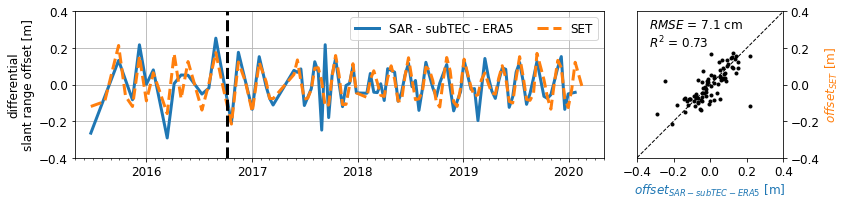

In [20]:
# dset 1: SAR - TEC
x1 = ptime.date_list2vector(date_list)[0]
y1  = np.array(iDict['SAR']['med'])
y1 -= np.array(iDict[tec_type]['med']) * (-1 if proj_name == 'ChileSenAT149' else 1)
y1 -= np.array(iDict['ERA5']['med'])

# dset 2: SET
y2  = np.array(iDict['SET']['med'])

# align all data with a constant
y1 -= np.nanmedian(y1)
y2 -= np.nanmedian(y2 - y1)

# plot - ts figure
fig = plt.figure(figsize=figsize)
gs  = gridspec.GridSpec(3, 12, figure=fig)
ax  = fig.add_subplot(gs[:, 0:-3])
ax2 = fig.add_subplot(gs[:, -3:])
ps = []
for i, (y, c, m) in enumerate(zip([y1, y2], ['C0', 'C1'], ['-', '--'])):
    flag = ~np.isnan(y)
    y  = np.array(y)[flag]
    x  = np.array(x1)[flag]
    p1, = ax.plot(x[:-1], np.diff(y), m, color=c, ms=6)
    ps.append((p1))
# axis format
ax.axvline(x=dt_s1ab, linestyle='--', color='k')   # S1A / S1B
xname = 'SAR - {} - ERA5'.format(tec_type)
ax.legend(labels=[xname, 'SET'], handles=ps, loc='best', ncol=len(ps))
if proj_name == 'ChileSenAT149':
    vstep = 0.2; ylim = [-0.4, 0.4]; xlim = [dt.datetime(2015, 5, 1), dt.datetime(2020, 5, 1)]
elif proj_name == 'ChileSenDT156':
    vstep = 0.3; ylim = [-0.5, 0.5]; xlim = None
utils.adjust_ts_axis_format(ax, x=x1, vstep=vstep, xlim=xlim, ylim=ylim, ylabel='differential\nslant range delay [m]')

# plot - dot figure
utils.plot_dot_figure(ax2, x=np.diff(y1), y=np.diff(y2), xname=xname, yname='SET', vlim=ylim, vstep=vstep)
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'DIFF_TS_SAR_{}_ERA5_vs_SET.png'.format(tec_type))
print('save figure to file', out_fig)
if save:
    plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()